<a href="https://colab.research.google.com/github/estebanhernandezr/Entregas-Semanales/blob/main/AndreyEsteban_LizarazoHernandez_ejerciciosCV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

A continuación, **importamos** las **librerías** necesarias...

In [113]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import datasets
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn import preprocessing
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.utils import resample

A continuación, **importamos** el **dataset iris**, los **regresores** y el **target** en dataframes por separado y luego los **concatenamos** en un solo **dataframe**...

In [114]:
# Dataset IRIS
iris = datasets.load_iris()
# Regresores
df_observ = pd.DataFrame(data=iris.data, columns=iris.feature_names)
# Target (0=setosa, 1=versicolor, 2=virginica)
df_target = pd.DataFrame(data=iris.target, columns=['label'])
df_target['name'] = df_target['label'].apply(lambda x: iris.target_names[x])
# Dataframe completo (regresores junto a su etiqueta correspondiente)
df_comple = pd.concat([df_observ, df_target], axis=1)
df_comple

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),label,name
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa
...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2,virginica
146,6.3,2.5,5.0,1.9,2,virginica
147,6.5,3.0,5.2,2.0,2,virginica
148,6.2,3.4,5.4,2.3,2,virginica


Tenemos un **dataframe** compuesto por **150 observaciones** de **4 características** y **una etiqueta** (**label** + **name**). Cuando graficamos dos de las características (**petal length** y **petal width**), podemos ver cómo se separan los datos en las **3 clases** distintas: **setosa**, **versicolor** y **virginica**.

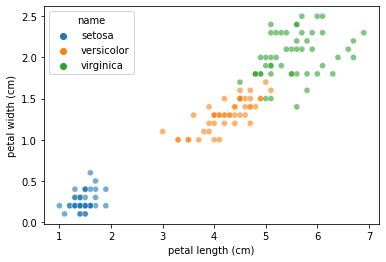

In [115]:
sns.scatterplot(x='petal length (cm)', y='petal width (cm)', hue='name', data=df_comple, alpha=0.6);

A continuación, podemos ver la **proyección** de los datos sobre el **eje y**.

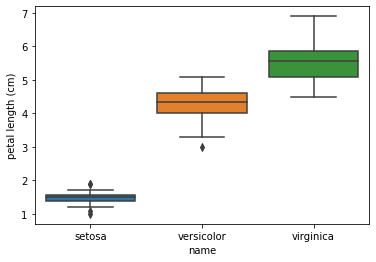

In [116]:
sns.boxplot(y='petal length (cm)', x='name',data=df_comple);

A continuación, podemos ver la **proyección** de los datos sobre el **eje x**.

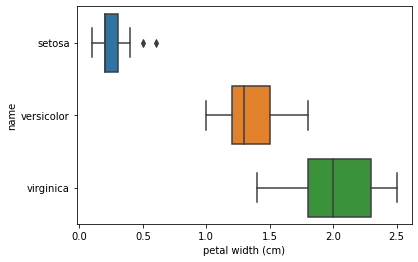

In [117]:
sns.boxplot(x='petal width (cm)', y='name',data=df_comple);

Podemos comprobar cómo las características **petal width** y **petal length** separan satisfactoriamente las 3 clases: sus medias están separadas y sus variaciones son lo suficientemente pequeñas que no se sobrelapan demasiado. 

Debido a que las clases se separan lo suficientemente bien con las dos características **petal width** y **petal length**, usaremos solo estas dos para entrenar tres modelos diferentes: **KNN**, **Regresión Logistica** y **K-means**.

A continuación, separamos el dataframe en **datos de prueba** y **datos de entrenamiento**.

In [118]:
# Dataframe con columnas "petal width" y "petal length" de 150 observaciones
X = df_observ.iloc[:, :]
# Dataframe columna "label" de 150 observaciones
y = df_target.iloc[:, 0]
# Separación de los datos en datos de prueba y entrenamiento
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

En la siguiente celda de código, definimos algunas **funciones** que serán de utilidad para **evaluar** las siguientes características del modelo:
*   **Exactitud**
*   **Precisión**
*   **Sensibilidad**
*   **Especificidad**
*   **Proporción de falsos positivos**

Para esto, las funciones a continuación reciben como entrada el vector de etiquetas predichas por algún modelo y el vector de etiquetas fácticas para el conjunto de datos de prueba. De esta manera, podemos saber cuántos falsos positivos en la predicción tuvo el modelo, así como cuántos falsos negativos. Esto último, nos permitirá calcular las medidas de correctitud del modelo y evaluarlo de la manera más objetiva posible.





In [119]:
# Nice function to calculate and visualize the confusion matrix
def plotCM(ytrue, ypred, labels, verbose=True):    
    CM = confusion_matrix(ytrue, ypred)
    
    if verbose:
        ax = sns.heatmap(CM, annot=True, cmap='Blues')

        ax.set_title('Seaborn Confusion Matrix with labels\n\n');
        ax.set_xlabel('\nPredicted Values')
        ax.set_ylabel('Actual Values ');

        ax.xaxis.set_ticklabels(labels)
        ax.yaxis.set_ticklabels(labels)

        ## Display the visualization of the Confusion Matrix.
        plt.show()
    return CM

def plotCentroids(kmeans_model):
    # Prediciendo lso grupos
    C = kmeans_model.cluster_centers_

    plt.figure()
    sns.scatterplot(x='petal length (cm)', y='petal width (cm)', hue='name', data=df_comple, alpha=0.6);
    plt.scatter(C[:, 0], C[:, 1], marker='x', c='black', s=70)
    plt.show()

def calculate_accuracy(CM):
    tn, fp, fn, tp = CM.ravel()
    accuracy = (tn+tp)/(tn+fp+fn+tp)
    return accuracy

def calculate_precission(CM):
    tn, fp, fn, tp = CM.ravel()
    precission = tp/(tp+fp)
    return precission

def calculate_sensibility(CM):
    tn, fp, fn, tp = CM.ravel()
    sensibility = tp/(tp+fn)
    return sensibility

def calculate_specificity(CM):
    tn, fp, fn, tp = CM.ravel()
    specificity = tn/(tn+fp)
    return specificity

def calculate_FPP(CM):
    tn, fp, fn, tp = CM.ravel()
    FPP = fp/(tn+fp)
    return FPP

A continuación, definimos algunas funciones que permiten entrenar los siguientes modelos, recibiendo como entrada algunos de los hiper-parámetros para los modelos y retornan los modelos entrenados con esos hiper-parámetros de entrada:
1.   **KNN** ( ***hyper-parámetros:*** número de vecinos **+** métrica de cercania )
2.   **Regresión Logística** (***hyper-parámetros:*** learning rate )
3.   **K-means** ( ***hyper-parámetros:*** número de clusters **+** métrica dissimilaridad )






In [120]:
def generate_knn_model(k, X_param=X_train, y_param=y_train):
    #print('generating knn model with hyper-parameters: ', k)
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(X_param, y_param)
    return knn_model

def generate_logic_regression_model(learn_rate, X_param=X_train, y_param=y_train):
    #print('generating logistic regression model with hyper-parameters: ', learn_rate)
    log_reg_model = LogisticRegression(max_iter=5000)
    log_reg_model.fit(X_param, y_param)
    return log_reg_model

def generate_kmeans_model(n, X_param=X_train, y_param=y_train):
    #print('generating k means model with hyper-parameters: ', n)
    kmeans_model = KMeans(n_clusters=n, random_state=10)
    kmeans_model.fit(X_param)
    return kmeans_model

A continuación, **generamos** alguno de los **tres modelos** y los entrenamos con el conjunto de datos de entrenamiento.

In [121]:
modelo = generate_knn_model(3)
predicciones = modelo.predict(X_test)

A continuación, visualizamos el resultado: la matriz de confusión para los tres métodos y los centroides para el modelo K-Means, etc.

Debemos tener en cuenta que el modelo de **k-means** es un modelo de **aprendizaje no supervisado**, como tal, la matriz de confusión podría fallar al no asignar las etiquetas apropiadamente. Para el caso del modelo de **k-means** lo que en realidad nos interesa es visulizar los **clusters**, para esto se definen algunos métodos especiales de visualización que funcionan únicamente para k-means y no funcionarán para los otros métodos: ***plotCentroids($\cdot$)***, etc. (puede comentar estas líneas de código cuando no esté trabajando con el modelo de k-means)

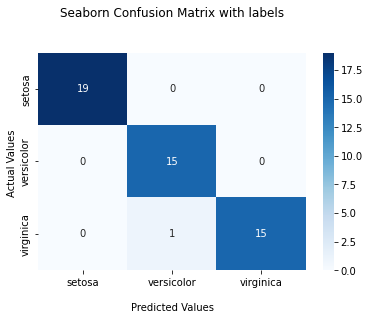

array([[19,  0,  0],
       [ 0, 15,  0],
       [ 0,  1, 15]])

In [122]:
#plotCentroids(modelo) # ONLY VALID FOR K-MEANS MODEL (ERROR OTHERWISE)
plotCM(y_test, predicciones, sorted(iris.target_names))

Ya que sabemos cómo generar los modelos y visualizar el resultado de su clasificación, estamos listos para **estimar** los mejores **hiper-parámetros** para cada uno de los modelos haciendo **Cross Validation** y **Bootstrap** más adelante.

**Antes** de realizar el **Cross Validation** y el **Bootstrap** debemos convertir el **clasificador multi-clase** a **clasificador binario** para poder calcular la principales medidas de rendimiento para los clasificadores, especificadas arriba. Para esto definimos una función que implementa un **clasificador binario** dado un modelo **multi-clase**. Para esto, clasificamos el conjunto de datos de prueba y comparamos las etiquetas predichas con las etiquetas del conjunto de prueba.

In [123]:
def predict_class(model, label):
    y_pred = model.predict(X_test)
    y_pred = [1 if x == label else 0 for x in y_pred]
    y_test_local = [1 if x == label else 0 for x in y_test]
    return y_pred

def plotCM_class(model, label, verbose=True):
    CM = plotCM([1 if x == label else 0 for x in y_test], predict_class(model, label), [0, 1], verbose)
    return CM

A continuación, comprobamos cómo funcionaría la función de **predicción de clase** para el ***modelo*** que hemos definido arriba. También vamos a utilizar las funciones que calculan las medidas de rendimiento del modelo para la matríz de decisión resultante.

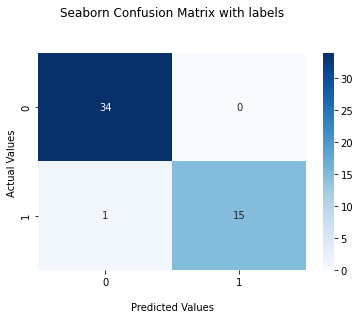

exact:  0.98  preci:  1.0  sensi:  0.9375  espec:  1.0  PFP:  0.0


In [124]:
matriz_confusion = plotCM_class(modelo, 2)
exactitud = calculate_accuracy(matriz_confusion)
precision = calculate_precission(matriz_confusion)
sensibilidad = calculate_sensibility(matriz_confusion)
especificidad = calculate_specificity(matriz_confusion)
PFP = calculate_FPP(matriz_confusion)

print('exact: ', exactitud, ' preci: ', precision, ' sensi: ', sensibilidad, ' espec: ', especificidad, ' PFP: ', PFP)

Note que, la matriz de decision está dada de la siguiente manera:

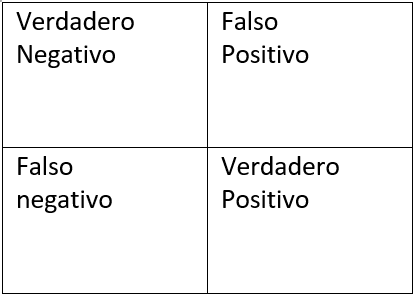

Ahora si: a continuación, definimos las funciones para realizar el **Cross Validation** y el **Bootstrap**; una función diferente para cada modelo, ya que cada uno posee sus propios hiper-parámetros.

In [125]:
def cross_validate_knn(K, label):
    for k in range(1, K):
        print('generating knn model with hyper-parameters: ', k)
        kf = KFold(n_splits=10) 
        kf.get_n_splits(X)
        history_validation = pd.DataFrame()
        for train_index, test_index in kf.split(X):
            X_train_param, X_test_param = X.iloc[train_index, :], X.iloc[test_index, :]
            y_train_param, y_test_param = y[train_index], y[test_index]

            model = generate_knn_model(k, X_train_param, y_train_param)
            matriz_confusion = plotCM_class(model, label, False)
            exactitud = calculate_accuracy(matriz_confusion)
            precision = calculate_precission(matriz_confusion)
            sensibilidad = calculate_sensibility(matriz_confusion)
            especificidad = calculate_specificity(matriz_confusion)
            PFP = calculate_FPP(matriz_confusion)
            
            pd_validation = pd.DataFrame(data={
                        'exact': exactitud,
                        'prec': precision,
                        'sens': sensibilidad,
                        'espec': especificidad,
                        'FPP': PFP
                    }, index = [k])

            history_validation = pd.concat(objs=[history_validation, pd_validation])
        print('Cross validation measures with hyper-parameters: ', k)
        print(history_validation.mean(axis = 0))

def cross_validate_logic_regression(vect, label):
    for alpha in vect:
        print('generating logistic regression model with hyper-parameters: ', alpha)
        kf = KFold(n_splits=10) 
        kf.get_n_splits(X)
        history_validation = pd.DataFrame()
        for train_index, test_index in kf.split(X):
            X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
            y_train, y_test = y[train_index], y[test_index]

            model = generate_logic_regression_model(alpha)
            matriz_confusion = plotCM_class(model, label, False)
            exactitud = calculate_accuracy(matriz_confusion)
            precision = calculate_precission(matriz_confusion)
            sensibilidad = calculate_sensibility(matriz_confusion)
            especificidad = calculate_specificity(matriz_confusion)
            PFP = calculate_FPP(matriz_confusion)

            pd_validation = pd.DataFrame(data={
                'exact': exactitud,
                'prec': precision,
                'sens': sensibilidad,
                'espec': especificidad,
                'FPP': PFP
            }, index = [alpha])

            history_validation = pd.concat(objs=[history_validation, pd_validation])
        print('Cross validation measures with hyper-parameters: ', alpha)
        print(history_validation.mean(axis = 0))

def cross_validate_kmeans(N, label):
    for n in range(1, N):
        print('generating k means model with hyper-parameters: ', n)
        kf = KFold(n_splits=10) 
        kf.get_n_splits(X)
        history_validation = pd.DataFrame()
        for train_index, test_index in kf.split(X):
            X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
            y_train, y_test = y[train_index], y[test_index]

            model = generate_kmeans_model(n)
            matriz_confusion = plotCM_class(model, label, False)
            exactitud = calculate_accuracy(matriz_confusion)
            precision = calculate_precission(matriz_confusion)
            sensibilidad = calculate_sensibility(matriz_confusion)
            especificidad = calculate_specificity(matriz_confusion)
            PFP = calculate_FPP(matriz_confusion)

            pd_validation = pd.DataFrame(data={
                'exact': exactitud,
                'prec': precision,
                'sens': sensibilidad,
                'espec': especificidad,
                'FPP': PFP
            }, index = [n])

            history_validation = pd.concat(objs=[history_validation, pd_validation])
        print('Cross validation measures with hyper-parameters: ', n)
        print(history_validation.mean(axis = 0))

A continuación, realizamos el **Cross Validation** para un modelo de **KNN**:

1.   Ingresamos una **clase para diferenciar del resto**, inicializamos el **modelo binario** para distinguir esa clase del resto.
2.   Ingresamos un **rango para variar los hiper-parámetros** de los modelos.
3.   Para **cada valor de los hiper-parámetros**, realizamos **Cross Validation** para **10 folds**.
4.   **Guardamos** los valores de la **medidas de correctitud** del modelo en cada iteración en un **dataframe** y al final graficamos el promedio de cada medida para cada valor de los hiper-parámetros.





In [126]:
cross_validate_knn(10, 2)

generating knn model with hyper-parameters:  1
Cross validation measures with hyper-parameters:  1
exact    0.99800
prec     1.00000
sens     0.99375
espec    1.00000
FPP      0.00000
dtype: float64
generating knn model with hyper-parameters:  2
Cross validation measures with hyper-parameters:  2
exact    0.97800
prec     1.00000
sens     0.93125
espec    1.00000
FPP      0.00000
dtype: float64
generating knn model with hyper-parameters:  3
Cross validation measures with hyper-parameters:  3
exact    0.984
prec     1.000
sens     0.950
espec    1.000
FPP      0.000
dtype: float64
generating knn model with hyper-parameters:  4
Cross validation measures with hyper-parameters:  4
exact    0.9800
prec     1.0000
sens     0.9375
espec    1.0000
FPP      0.0000
dtype: float64
generating knn model with hyper-parameters:  5
Cross validation measures with hyper-parameters:  5
exact    0.994000
prec     0.994118
sens     0.987500
espec    0.997059
FPP      0.002941
dtype: float64
generating knn 

De acuerdo a lo que podemos ver empíricamente, el valor óptimos para los parámetros de un modelo **KNN** para este conjunto de datos en particular es: **k=8**.

A continuación, realizamos el **Cross Validation** para un modelo de **Regresión logística**:

1.   Ingresamos una **clase para diferenciar del resto**, inicializamos el **modelo binario** para distinguir esa clase del resto.
2.   Ingresamos un **rango para variar los hiper-parámetros** de los modelos.
3.   Para **cada valor de los hiper-parámetros**, realizamos **Cross Validation** para **10 folds**.
4.   **Guardamos** los valores de la **medidas de correctitud** del modelo en cada iteración en un **dataframe** y al final graficamos el promedio de cada medida para cada valor de los hiper-parámetros.

In [127]:
cross_validate_logic_regression([0.05, 0.1, 0.2, 0.5, 0.6, 0.7], 2)

generating logistic regression model with hyper-parameters:  0.05
Cross validation measures with hyper-parameters:  0.05
exact    1.0
prec     1.0
sens     1.0
espec    1.0
FPP      0.0
dtype: float64
generating logistic regression model with hyper-parameters:  0.1
Cross validation measures with hyper-parameters:  0.1
exact    1.0
prec     1.0
sens     1.0
espec    1.0
FPP      0.0
dtype: float64
generating logistic regression model with hyper-parameters:  0.2
Cross validation measures with hyper-parameters:  0.2
exact    1.0
prec     1.0
sens     1.0
espec    1.0
FPP      0.0
dtype: float64
generating logistic regression model with hyper-parameters:  0.5
Cross validation measures with hyper-parameters:  0.5
exact    1.0
prec     1.0
sens     1.0
espec    1.0
FPP      0.0
dtype: float64
generating logistic regression model with hyper-parameters:  0.6
Cross validation measures with hyper-parameters:  0.6
exact    1.0
prec     1.0
sens     1.0
espec    1.0
FPP      0.0
dtype: float64
gen

De acuerdo a lo que podemos ver empíricamente, el valor óptimos para los parámetros de un modelo **Regresión Logística** para este conjunto de datos en particular es: **alpha cualquiera**. Parece ser que el modelo está realizando overfitting sobre el conjunto de datos iris. Por lo tanto se concluye que es necesario realizar regularización.

A continuación, realizamos el **Cross Validation** para un modelo de **K means**:

1.   Ingresamos una **clase para diferenciar del resto**, inicializamos el **modelo binario** para distinguir esa clase del resto.
2.   Ingresamos un **rango para variar los hiper-parámetros** de los modelos.
3.   Para **cada valor de los hiper-parámetros**, realizamos **Cross Validation** para **10 folds**.
4.   **Guardamos** los valores de la **medidas de correctitud** del modelo en cada iteración en un **dataframe** y al final graficamos el promedio de cada medida para cada valor de los hiper-parámetros.

In [128]:
cross_validate_kmeans(10, 2)

generating k means model with hyper-parameters:  1
Cross validation measures with hyper-parameters:  1
exact    0.68
prec      NaN
sens     0.00
espec    1.00
FPP      0.00
dtype: float64
generating k means model with hyper-parameters:  2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/p

Cross validation measures with hyper-parameters:  2
exact    0.68
prec      NaN
sens     0.00
espec    1.00
FPP      0.00
dtype: float64
generating k means model with hyper-parameters:  3
Cross validation measures with hyper-parameters:  3
exact    0.480000
prec     0.222222
sens     0.250000
espec    0.588235
FPP      0.411765
dtype: float64
generating k means model with hyper-parameters:  4
Cross validation measures with hyper-parameters:  4
exact    0.84
prec     1.00
sens     0.50
espec    1.00
FPP      0.00
dtype: float64
generating k means model with hyper-parameters:  5
Cross validation measures with hyper-parameters:  5
exact    0.8600
prec     1.0000
sens     0.5625
espec    1.0000
FPP      0.0000
dtype: float64
generating k means model with hyper-parameters:  6
Cross validation measures with hyper-parameters:  6
exact    0.660000
prec     0.000000
sens     0.000000
espec    0.970588
FPP      0.029412
dtype: float64
generating k means model with hyper-parameters:  7
Cross vali

De acuerdo a lo que podemos ver empíricamente, el valor óptimos para los parámetros de un modelo **K means** para este conjunto de datos en particular es: **n=4**.

Ahora vamos a implementar **Bootstrap** sobre el conjunto de datos, esto con objetivo de comprobar la estabilidad y precisión de los mejores modelos encontrados en el **Cross validation**: para eso definimos los modelos con el valor óptimo de sus parámetros, de acuerdo a las mediciones de **exactitud**, **precisión**, **sensibilidad**, **especificidad** y **PFP** que acabamos de determinar por medio del **Cross Validation** para cada valor de los parámetros.

In [129]:
#regression_model:
modelo_boots_regre= LogisticRegression()
#kmeans_model:
modelo_boots_kmeans = KNeighborsClassifier(n_neighbors=8)
#knn_model:
modelo_boots_knn = KNeighborsClassifier(n_neighbors=4)

A continuación, definimos la función que realizará el **Bootstrap** para un **modelo** y número de **iteraciones** **dados**. Se almacenan las mediciones de correctitud del modelo en cada iteración en un dataframe y al final se grafican los resultados.

In [130]:
def model_bootstrap(modelo, label, n_iterations):
    bootstrapped_stats = pd.DataFrame()
    for i in range(n_iterations):
        train = resample(df_comple, replace=True, n_samples=(df_comple.shape[0]))
        test = df_comple[~df_comple.index.isin(train.index)]
        X_train_local = train.loc[:, ["petal length (cm)","petal width (cm)","sepal length (cm)", "sepal width (cm)"]]
        y_train_local = train.loc[:, "label"]

        X_test_local = test.loc[:, ["petal length (cm)","petal width (cm)","sepal length (cm)", "sepal width (cm)"]]
        y_test_local = test.loc[:, "label"]

        modelo.fit(X_train_local, y_train_local)

        matriz_confusion = plotCM_class(modelo, label, False)
        exactitud = calculate_accuracy(matriz_confusion)
        precision = calculate_precission(matriz_confusion)
        sensibilidad = calculate_sensibility(matriz_confusion)
        especificidad = calculate_specificity(matriz_confusion)
        PFP = calculate_FPP(matriz_confusion)

        bootstrapped_stats_i = pd.DataFrame(data={
            'exact': exactitud,
            'prec': precision,
            'sens': sensibilidad,
            'espec': especificidad,
            'FPP': PFP
        }, index = [i])

        bootstrapped_stats = pd.concat(objs=[bootstrapped_stats, bootstrapped_stats_i])
    return bootstrapped_stats

In [131]:
n = 50
etiqueta = 2

bootstrapped_res = model_bootstrap(modelo_boots_kmeans, etiqueta, n)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed d

A continuación, visualizamos el promedio del error para cada una de las medidas de correctitud del modelo.

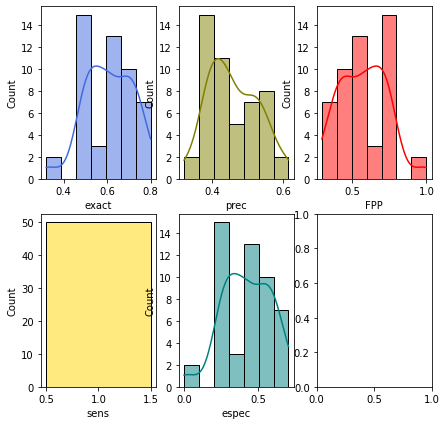

In [132]:
fig, axes = plt.subplots(2, 3, figsize=(7, 7))
sns.histplot(bootstrapped_res["exact"], color="royalblue", ax=axes[0, 0], kde=True)
sns.histplot(bootstrapped_res["prec"], color="olive", ax=axes[0, 1], kde=True)
sns.histplot(bootstrapped_res["sens"], color="gold", ax=axes[1, 0], kde=True)
sns.histplot(bootstrapped_res["espec"], color="teal", ax=axes[1, 1], kde=True)
sns.histplot(bootstrapped_res["FPP"], color="red", ax=axes[0, 2], kde=True)